In [1]:
import json
import os
import argparse
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy
from hyperparams import STRATEGY
from PLP.DSL import *
from strategy_demonstrations import make_modified_env
from decision_tree_imitation_learning import solve_mouselab
from scipy import stats
from datetime import datetime

import read_csv_to_dataframe as ecf
import experiment_participant_analysis as epa
from importlib import reload

pd.set_option('display.max_rows', 181)
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_colwidth', 60)

In [2]:
# import data as csv
exp_version = '4A'
dataclip = pd.read_csv('data/Exp'+exp_version+'/dataclip.csv')


In [4]:
#set up
reload(ecf)
dataframe1 = ecf.makeDataframe(dataclip, ecf.getParticipantInfoExp4A)
dataframe1 = dataframe1.sort_values(by=['condition'], ascending=True)
dataframe1.reset_index(inplace = True, drop=True)

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
# ............................ ANONYMIZE AND Stroring .....................................................
# ..........................................................................................
# ..........................................................................................

In [7]:
data = dataframe1.drop(columns=['WorkerId', 'hitId', 'assignmentId','datastring'])
data.apply(lambda x: (json.dumps(a) for a in x) if x.name in 'testingTrials' else x).to_csv('data/Exp'+exp_version+'/dataframe_raw.csv', index_label='pid')



In [8]:
# ............................ CALCULATE PAIR AGREEMENT .....................................................
# ..........................................................................................
# ..........................................................................................

In [5]:
exp_version = '4B'

if exp_version == '4A':
    plp_tree = 'lambda st, act : ((among(st, act, lambda st, act:  not(is_observed(st, act)) ,  lambda st, act, lst: has_largest_depth(st, act, lst) ) and not (is_previous_observed_max(st, act))))'
elif exp_version == '4B':
    plp_tree = 'lambda st, act : ((among(st, act, lambda st, act:  is_root(st, act)  and  not(is_observed(st, act)) )))'
elif exp_version == '4C':
    plp_tree =   'lambda st, act : ((among(st, act, lambda st, act:  not(is_leaf(st, act)) ,  lambda st, act, lst: has_best_path(st, act, lst) ) and among(st, act, lambda st, act:  not(is_max_in_branch(st, act))  and  not(is_observed(st, act)) ))) or ((not (among(st, act, lambda st, act:  not(is_leaf(st, act)) ,  lambda st, act, lst: has_best_path(st, act, lst) )) and among(st, act, lambda st, act:  is_max_in_branch(st, act)  and  not(is_observed(st, act)) )))'

dataframe2 = pd.read_csv('data/Exp'+exp_version+'/dataframe_raw.csv')
dataframe2 = dataframe2.apply(lambda x: (json.loads(a) for a in x) if x.name in 'testingTrials' else x)

if(False):
    pas = epa.get_agreement_sample(dataframe2.testingTrials, plp_tree)
    dataframe2['pa_mean'] = pas['click_agreement_means_sample']
    dataframe2['pa_complete'] = pas['click_agreement_ratios_sample']
    dataframe2['pa_et'] = pas['mean_run_lengths_sample']
else:
    pas = pd.read_csv('data/Exp'+exp_version+'/dataframe_complete.csv')
    dataframe2['pa_mean'] = pas['pa_mean']
    dataframe2['pa_complete'] = pas['pa_complete']
    dataframe2['pa_et'] = pas['pa_et']

In [11]:
# ............................ ANONYMIZE AND Stroring .....................................................
# ..........................................................................................
# ..........................................................................................

In [12]:
data = dataframe2.drop(columns=['testingTrials'])
data.to_csv('data/Exp'+exp_version+'/dataframe_complete.csv', index=False)

In [13]:
# ............................Filter.................................................
# .............................................................................
# .............................................................................

In [14]:
dataframe1['pa_mean'] = dataframe2['pa_mean']
df_valid_all = dataframe1[dataframe1.status != 6]
df_valid_all.reset_index(inplace = True, drop=True)
print(len(df_valid_all))

159


In [15]:
# ............................BONUS.................................................
# ..........................................................................................
# ..........................................................................................

In [16]:
#df_valid_all

In [17]:
bon = []
for index, row in df_valid_all.iterrows():
    if row['condition'] == 0:
        bon.append(row['pa_mean'] * 0.5)
    else: 
        bon.append(max(0, min(0.5,np.sum(row['scores']) * 0.02) ))
        
df_valid_all['bonus'] = bon

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.30830345911949686
0.0
0.5


(array([19.,  7.,  6., 15., 15., 20., 11.,  3.,  2., 61.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <a list of 10 Patch objects>)

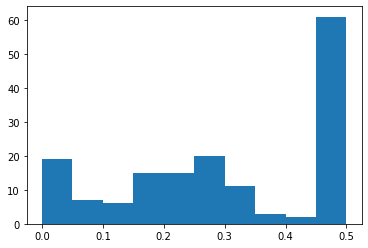

In [18]:
# bonus stats:
print(np.mean(df_valid_all['bonus']))
print(np.min(df_valid_all['bonus']))
print(np.max(df_valid_all['bonus']))
plt.hist(df_valid_all.bonus)

In [19]:
ecf.exportBonus(df_valid_all, total_bonus = False, exp_version= exp_version)

In [20]:
df_valid_all.totalTime.mean()

11.766037735849059